# Notebook 19: Probabilistic Programming with Pyro

## Learning Objectives

By the end of this notebook, you will:
1. Understand Pyro's core primitives (`sample`, `param`, `plate`)
2. Build probabilistic models with the model/guide pattern
3. Perform variational inference with SVI
4. Implement a proper Bayesian Neural Network
5. Compare Pyro BNNs to MC Dropout and Ensembles

**Prerequisites**: Notebook 18 (Uncertainty Quantification), basic probability

In [1]:
# Install Pyro if needed
# !pip install pyro-ppl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from pyro.nn import PyroModule, PyroSample
import pyro.infer.autoguide as autoguide

# Clear param store (important for re-running cells)
pyro.clear_param_store()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Pyro version: {pyro.__version__}")

torch.manual_seed(42)
pyro.set_rng_seed(42)

Using device: cuda
Pyro version: 1.9.1


---
## 1. Pyro Fundamentals

Pyro extends PyTorch with probabilistic primitives:

| Primitive | Purpose |
|-----------|--------|
| `pyro.sample` | Draw from a distribution (random variable) |
| `pyro.param` | Learnable parameter (like `nn.Parameter`) |
| `pyro.plate` | Declare independent observations (vectorization) |

### The Model/Guide Pattern

- **Model**: Defines the generative process (prior + likelihood)
- **Guide**: Defines the approximate posterior (what we learn)

In [2]:
# Basic example: sampling from distributions
def simple_model():
    # Sample from a prior
    mu = pyro.sample("mu", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1))
    
    # Sample observation
    obs = pyro.sample("obs", dist.Normal(mu, sigma))
    return obs

# Run the model (prior sampling)
samples = [simple_model() for _ in range(1000)]
print(f"Mean of samples: {np.mean(samples):.3f}")
print(f"Std of samples: {np.std(samples):.3f}")

Mean of samples: 0.018
Std of samples: 3.097


In [3]:
# Conditioning on observations
def model_with_obs(data):
    mu = pyro.sample("mu", dist.Normal(0, 10))  # Prior on mean
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1))  # Prior on std
    
    # Plate for independent observations
    with pyro.plate("data", len(data)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=data)

# Generate some data
true_mu, true_sigma = 5.0, 2.0
data = torch.randn(100) * true_sigma + true_mu

print(f"Data mean: {data.mean():.3f}, Data std: {data.std():.3f}")

Data mean: 5.343, Data std: 1.960


---
## 2. Bayesian Linear Regression

Let's start with a simple example: inferring the slope and intercept of a line.

$$y = wx + b + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

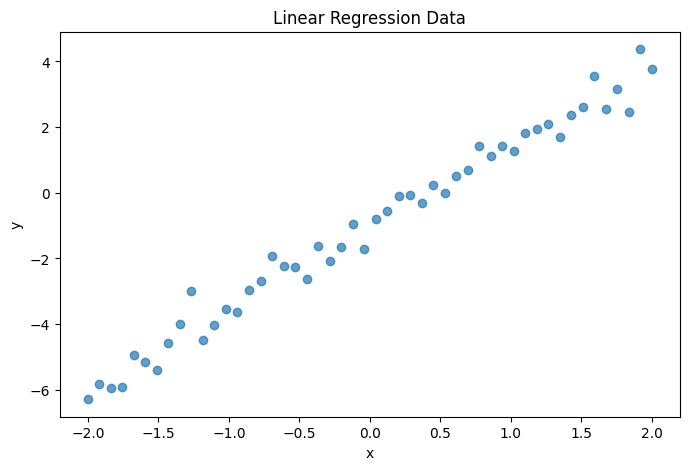

In [4]:
# Generate synthetic data
def generate_linear_data(n=100, w_true=2.5, b_true=-1.0, noise_std=0.5):
    x = torch.linspace(-2, 2, n)
    y = w_true * x + b_true + torch.randn(n) * noise_std
    return x, y

x_train, y_train = generate_linear_data(n=50)

plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression Data')
plt.show()

In [5]:
def linear_model(x, y=None):
    """Bayesian linear regression model."""
    # Priors
    w = pyro.sample("w", dist.Normal(0, 5))
    b = pyro.sample("b", dist.Normal(0, 5))
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1))
    
    # Likelihood
    mean = w * x + b
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
    
    return mean


def linear_guide(x, y=None):
    """Variational guide (approximate posterior)."""
    # Learnable parameters for q(w), q(b), q(sigma)
    w_loc = pyro.param("w_loc", torch.tensor(0.0))
    w_scale = pyro.param("w_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    
    b_loc = pyro.param("b_loc", torch.tensor(0.0))
    b_scale = pyro.param("b_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    
    sigma_loc = pyro.param("sigma_loc", torch.tensor(0.0))
    sigma_scale = pyro.param("sigma_scale", torch.tensor(0.5), constraint=dist.constraints.positive)
    
    # Sample from approximate posterior
    pyro.sample("w", dist.Normal(w_loc, w_scale))
    pyro.sample("b", dist.Normal(b_loc, b_scale))
    pyro.sample("sigma", dist.LogNormal(sigma_loc, sigma_scale))

Step 500, Loss: 62.43
Step 1000, Loss: 54.05
Step 1500, Loss: 36.97
Step 2000, Loss: 41.21


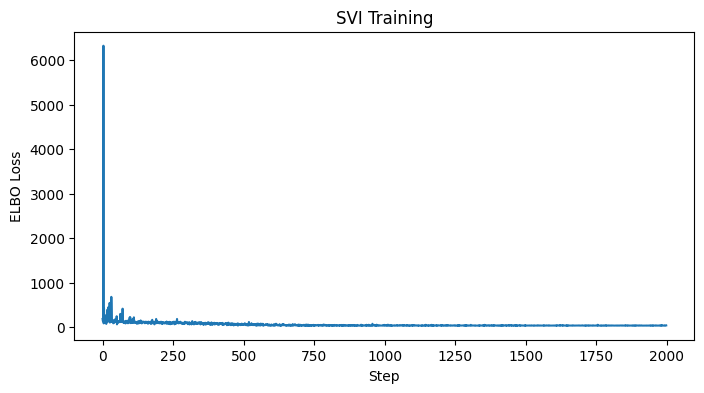

In [6]:
# Stochastic Variational Inference (SVI)
pyro.clear_param_store()

optimizer = Adam({"lr": 0.05})
svi = SVI(linear_model, linear_guide, optimizer, loss=Trace_ELBO())

losses = []
n_steps = 2000

for step in range(n_steps):
    loss = svi.step(x_train, y_train)
    losses.append(loss)
    
    if (step + 1) % 500 == 0:
        print(f"Step {step+1}, Loss: {loss:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('ELBO Loss')
plt.title('SVI Training')
plt.show()

In [7]:
# Examine learned parameters
print("Learned approximate posterior:")
print(f"  w ~ N({pyro.param('w_loc').item():.3f}, {pyro.param('w_scale').item():.3f})")
print(f"  b ~ N({pyro.param('b_loc').item():.3f}, {pyro.param('b_scale').item():.3f})")
print(f"  sigma ~ LogN({pyro.param('sigma_loc').item():.3f}, {pyro.param('sigma_scale').item():.3f})")
print(f"\nTrue values: w=2.5, b=-1.0, sigma=0.5")

Learned approximate posterior:
  w ~ N(2.455, 0.050)
  b ~ N(-1.103, 0.054)
  sigma ~ LogN(-0.815, 0.174)

True values: w=2.5, b=-1.0, sigma=0.5


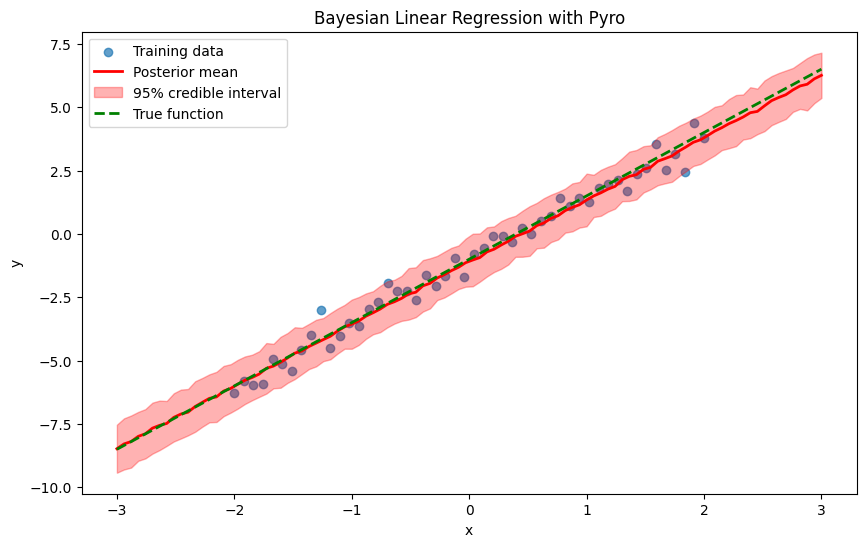

In [8]:
# Posterior predictive
predictive = Predictive(linear_model, guide=linear_guide, num_samples=200)
x_test = torch.linspace(-3, 3, 100)

samples = predictive(x_test)
obs_samples = samples["obs"]  # [num_samples, num_points]

mean_pred = obs_samples.mean(dim=0)
std_pred = obs_samples.std(dim=0)

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, alpha=0.7, label='Training data')
plt.plot(x_test, mean_pred, 'r-', label='Posterior mean', linewidth=2)
plt.fill_between(x_test, mean_pred - 2*std_pred, mean_pred + 2*std_pred,
                 alpha=0.3, color='red', label='95% credible interval')
plt.plot(x_test, 2.5 * x_test - 1.0, 'g--', label='True function', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Bayesian Linear Regression with Pyro')
plt.show()

---
## 3. AutoGuide: Automatic Guide Construction

Writing guides manually is tedious. Pyro provides automatic guides:

In [9]:
pyro.clear_param_store()

# AutoNormal: Mean-field Gaussian approximation
auto_guide = autoguide.AutoNormal(linear_model)

svi = SVI(linear_model, auto_guide, Adam({"lr": 0.05}), loss=Trace_ELBO())

for step in range(2000):
    svi.step(x_train, y_train)

# Get posterior samples
predictive = Predictive(linear_model, guide=auto_guide, num_samples=500)
samples = predictive(x_test)

print("Posterior statistics (AutoNormal guide):")
for name in ["w", "b", "sigma"]:
    vals = samples[name].squeeze()
    print(f"  {name}: mean={vals.mean():.3f}, std={vals.std():.3f}")

Posterior statistics (AutoNormal guide):
  w: mean=2.502, std=0.045
  b: mean=-1.032, std=0.058
  sigma: mean=0.420, std=0.049


---
## 4. Bayesian Neural Network with Pyro

Now let's build a proper BNN using `PyroModule`.

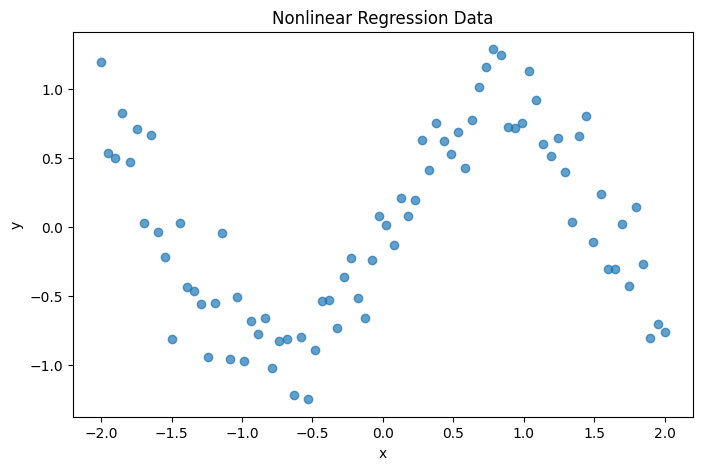

In [10]:
# Generate nonlinear regression data
def generate_nonlinear_data(n=100):
    x = torch.linspace(-2, 2, n).unsqueeze(1)
    y = torch.sin(2 * x) + 0.3 * torch.randn(n, 1)
    return x, y.squeeze()

x_nl, y_nl = generate_nonlinear_data(80)

plt.figure(figsize=(8, 5))
plt.scatter(x_nl, y_nl, alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nonlinear Regression Data')
plt.show()

In [11]:
class BayesianMLP(PyroModule):
    """Bayesian MLP using PyroModule."""
    
    def __init__(self, in_dim=1, hidden_dim=20, out_dim=1, prior_scale=1.0):
        super().__init__()
        
        # First layer
        self.fc1 = PyroModule[nn.Linear](in_dim, hidden_dim)
        self.fc1.weight = PyroSample(
            dist.Normal(0., prior_scale).expand([hidden_dim, in_dim]).to_event(2)
        )
        self.fc1.bias = PyroSample(
            dist.Normal(0., prior_scale).expand([hidden_dim]).to_event(1)
        )
        
        # Second layer
        self.fc2 = PyroModule[nn.Linear](hidden_dim, out_dim)
        self.fc2.weight = PyroSample(
            dist.Normal(0., prior_scale).expand([out_dim, hidden_dim]).to_event(2)
        )
        self.fc2.bias = PyroSample(
            dist.Normal(0., prior_scale).expand([out_dim]).to_event(1)
        )
    
    def forward(self, x, y=None):
        x = torch.tanh(self.fc1(x))
        mu = self.fc2(x).squeeze(-1)
        
        # Observation noise
        sigma = pyro.sample("sigma", dist.LogNormal(0., 1.))
        
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu

Step 1000, Loss: 133.36
Step 2000, Loss: 158.67
Step 3000, Loss: 105.95


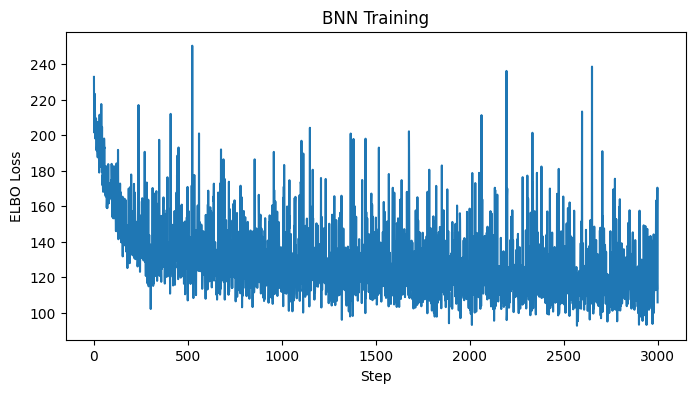

In [12]:
# Train BNN
pyro.clear_param_store()

bnn = BayesianMLP(in_dim=1, hidden_dim=20, out_dim=1, prior_scale=1.0)
guide = autoguide.AutoDiagonalNormal(bnn)

optimizer = Adam({"lr": 0.01})
svi = SVI(bnn, guide, optimizer, loss=Trace_ELBO())

losses = []
n_steps = 3000

for step in range(n_steps):
    loss = svi.step(x_nl, y_nl)
    losses.append(loss)
    
    if (step + 1) % 1000 == 0:
        print(f"Step {step+1}, Loss: {loss:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('ELBO Loss')
plt.title('BNN Training')
plt.show()

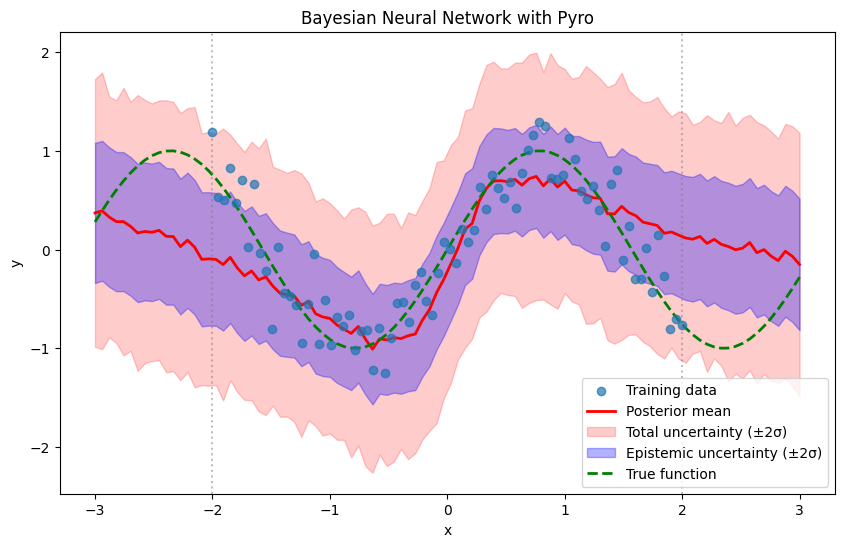

Note: Epistemic uncertainty increases outside training range [-2, 2]


In [17]:
# Posterior predictive with uncertainty
predictive = Predictive(bnn, guide=guide, num_samples=200)

x_test_nl = torch.linspace(-3, 3, 100).unsqueeze(1)
samples = predictive(x_test_nl)
obs_samples = samples["obs"]  # [num_samples, num_points]

mean_pred = obs_samples.mean(dim=0)
std_pred = obs_samples.std(dim=0)

# Compute epistemic uncertainty (from weight uncertainty)
# by looking at variance of the mean predictions
mu_samples = []
for i in range(200):
    guide_trace = pyro.poutine.trace(guide).get_trace(x_test_nl)
    model_trace = pyro.poutine.trace(
        pyro.poutine.replay(bnn, trace=guide_trace)
    ).get_trace(x_test_nl)
    # Get the mean (before noise)
    mu_samples.append(model_trace.nodes["_RETURN"]["value"])

mu_samples = torch.stack(mu_samples)
epistemic_std = mu_samples.std(dim=0)

plt.figure(figsize=(10, 6))
plt.scatter(x_nl, y_nl, alpha=0.7, label='Training data', zorder=5)
plt.plot(x_test_nl, mean_pred, 'r-', label='Posterior mean', linewidth=2)
plt.fill_between(x_test_nl.squeeze(), mean_pred - 2*std_pred, mean_pred + 2*std_pred,
                 alpha=0.2, color='red', label='Total uncertainty (±2σ)')
# plt.fill_between(x_test_nl.squeeze(), mean_pred - 2*epistemic_std, mean_pred + 2*epistemic_std,
#                  alpha=0.3, color='blue', label='Epistemic uncertainty (±2σ)')
plt.fill_between(x_test_nl.squeeze().detach(), 
                 (mean_pred - 2*epistemic_std).detach(), 
                 (mean_pred + 2*epistemic_std).detach(),
                 alpha=0.3, color='blue', label='Epistemic uncertainty (±2σ)')
plt.plot(x_test_nl, torch.sin(2 * x_test_nl), 'g--', label='True function', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Bayesian Neural Network with Pyro')
plt.axvline(x=-2, color='gray', linestyle=':', alpha=0.5)
plt.axvline(x=2, color='gray', linestyle=':', alpha=0.5)
plt.show()

print("Note: Epistemic uncertainty increases outside training range [-2, 2]")

---
## 5. BNN for Classification (MNIST)

In [18]:
from torchvision import datasets, transforms

# Load a subset of MNIST for speed
transform = transforms.ToTensor()
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('../data', train=False, transform=transform)

# Use subset for faster training
train_subset = torch.utils.data.Subset(mnist_train, range(5000))
test_subset = torch.utils.data.Subset(mnist_test, range(1000))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=128)

In [19]:
class BayesianClassifier(PyroModule):
    """Bayesian classifier for MNIST."""
    
    def __init__(self, in_dim=784, hidden_dim=128, out_dim=10, prior_scale=1.0):
        super().__init__()
        
        self.fc1 = PyroModule[nn.Linear](in_dim, hidden_dim)
        self.fc1.weight = PyroSample(
            dist.Normal(0., prior_scale).expand([hidden_dim, in_dim]).to_event(2)
        )
        self.fc1.bias = PyroSample(
            dist.Normal(0., prior_scale).expand([hidden_dim]).to_event(1)
        )
        
        self.fc2 = PyroModule[nn.Linear](hidden_dim, out_dim)
        self.fc2.weight = PyroSample(
            dist.Normal(0., prior_scale).expand([out_dim, hidden_dim]).to_event(2)
        )
        self.fc2.bias = PyroSample(
            dist.Normal(0., prior_scale).expand([out_dim]).to_event(1)
        )
    
    def forward(self, x, y=None):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        
        return logits

In [20]:
# Train Bayesian classifier
pyro.clear_param_store()

bnn_classifier = BayesianClassifier(prior_scale=0.5)
guide = autoguide.AutoDiagonalNormal(bnn_classifier)

optimizer = Adam({"lr": 0.005})
svi = SVI(bnn_classifier, guide, optimizer, loss=Trace_ELBO())

n_epochs = 10
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, y in train_loader:
        loss = svi.step(x, y)
        epoch_loss += loss
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.2f}")

Epoch 1/10, Loss: 109267.59
Epoch 2/10, Loss: 89304.11
Epoch 3/10, Loss: 72236.50
Epoch 4/10, Loss: 56878.01
Epoch 5/10, Loss: 43266.03
Epoch 6/10, Loss: 31685.86
Epoch 7/10, Loss: 22274.52
Epoch 8/10, Loss: 15101.64
Epoch 9/10, Loss: 9983.84
Epoch 10/10, Loss: 6606.21


In [21]:
# Evaluate with uncertainty
def predict_with_uncertainty(model, guide, x, num_samples=30):
    """Get predictions with uncertainty from BNN."""
    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=["obs", "_RETURN"])
    samples = predictive(x)
    
    # Get logits from multiple forward passes
    logits = samples["_RETURN"]  # [num_samples, batch, classes]
    probs = F.softmax(logits, dim=-1)
    
    mean_probs = probs.mean(dim=0)
    entropy = -(mean_probs * torch.log(mean_probs + 1e-10)).sum(dim=-1)
    
    return mean_probs, entropy

# Evaluate accuracy
correct = 0
total = 0
all_entropy = []

for x, y in test_loader:
    probs, entropy = predict_with_uncertainty(bnn_classifier, guide, x, num_samples=30)
    preds = probs.argmax(dim=-1)
    correct += (preds == y).sum().item()
    total += y.size(0)
    all_entropy.extend(entropy.numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")
print(f"Mean entropy: {np.mean(all_entropy):.4f}")

Test Accuracy: 68.20%
Mean entropy: 1.7929


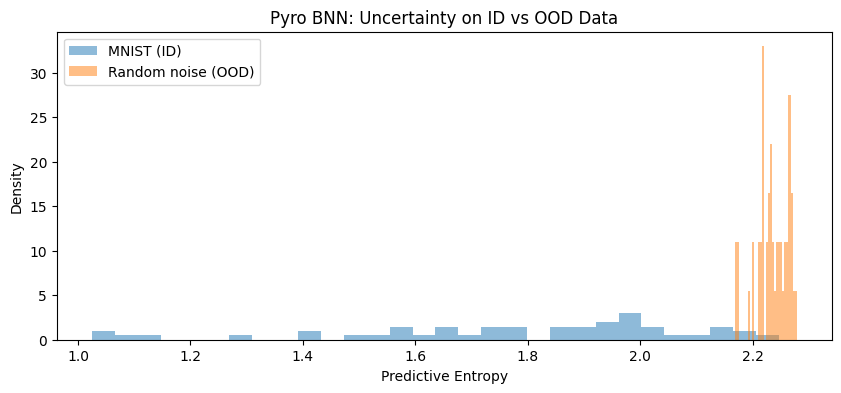

Mean entropy - ID: 1.7853, OOD: 2.2335


In [22]:
# Compare uncertainty on ID vs OOD (random noise)
x_id, _ = next(iter(test_loader))
x_ood = torch.rand_like(x_id)  # Random noise

_, entropy_id = predict_with_uncertainty(bnn_classifier, guide, x_id[:50], num_samples=50)
_, entropy_ood = predict_with_uncertainty(bnn_classifier, guide, x_ood[:50], num_samples=50)

plt.figure(figsize=(10, 4))
plt.hist(entropy_id.numpy(), bins=30, alpha=0.5, label='MNIST (ID)', density=True)
plt.hist(entropy_ood.numpy(), bins=30, alpha=0.5, label='Random noise (OOD)', density=True)
plt.xlabel('Predictive Entropy')
plt.ylabel('Density')
plt.legend()
plt.title('Pyro BNN: Uncertainty on ID vs OOD Data')
plt.show()

print(f"Mean entropy - ID: {entropy_id.mean():.4f}, OOD: {entropy_ood.mean():.4f}")

---
## 6. Comparison: Pyro BNN vs MC Dropout vs Ensemble

Let's compare uncertainty quality across methods.

In [23]:
# MC Dropout baseline
class MCDropoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.dropout(self.fc1(x)))
        return self.fc2(x)
    
    def predict_with_uncertainty(self, x, n_samples=30):
        self.train()  # Keep dropout on
        preds = [F.softmax(self(x), dim=1) for _ in range(n_samples)]
        preds = torch.stack(preds)
        mean_pred = preds.mean(dim=0)
        entropy = -(mean_pred * torch.log(mean_pred + 1e-10)).sum(dim=1)
        return mean_pred, entropy

# Train MC Dropout
mc_model = MCDropoutNet()
optimizer = torch.optim.Adam(mc_model.parameters(), lr=1e-3)

for epoch in range(10):
    mc_model.train()
    for x, y in train_loader:
        loss = F.cross_entropy(mc_model(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("MC Dropout trained")

MC Dropout trained


In [25]:
# Simple ensemble
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        return self.fc2(F.relu(self.fc1(x)))

ensemble = [SimpleNet() for _ in range(5)]

for i, model in enumerate(ensemble):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(10):
        model.train()
        for x, y in train_loader:
            loss = F.cross_entropy(model(x), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def ensemble_predict(models, x, n_samples=None):
    preds = [F.softmax(m(x), dim=1) for m in models]
    preds = torch.stack(preds)
    mean_pred = preds.mean(dim=0)
    entropy = -(mean_pred * torch.log(mean_pred + 1e-10)).sum(dim=1)
    return mean_pred, entropy

print("Ensemble trained")

Ensemble trained


In [26]:
# Compare OOD detection
from sklearn.metrics import roc_auc_score

def evaluate_ood(predict_fn, id_data, ood_data, **kwargs):
    _, ent_id = predict_fn(id_data, **kwargs)
    _, ent_ood = predict_fn(ood_data, **kwargs)
    
    labels = np.concatenate([np.zeros(len(ent_id)), np.ones(len(ent_ood))])
    scores = np.concatenate([ent_id.detach().numpy(), ent_ood.detach().numpy()])
    
    return roc_auc_score(labels, scores)

# Get test data
x_test_batch, _ = next(iter(test_loader))
x_ood_batch = torch.rand_like(x_test_batch)

# Evaluate each method
auroc_bnn = evaluate_ood(
    lambda x, **kw: predict_with_uncertainty(bnn_classifier, guide, x, num_samples=30),
    x_test_batch, x_ood_batch
)

auroc_mc = evaluate_ood(
    mc_model.predict_with_uncertainty,
    x_test_batch, x_ood_batch,
    n_samples=30
)

auroc_ens = evaluate_ood(
    lambda x, **kw: ensemble_predict(ensemble, x),
    x_test_batch, x_ood_batch
)

print("OOD Detection AUROC (higher is better):")
print(f"  Pyro BNN:   {auroc_bnn:.4f}")
print(f"  MC Dropout: {auroc_mc:.4f}")
print(f"  Ensemble:   {auroc_ens:.4f}")

OOD Detection AUROC (higher is better):
  Pyro BNN:   0.9413
  MC Dropout: 0.8218
  Ensemble:   0.8218


---
## 7. Summary

### Pyro Key Concepts

| Concept | Description |
|---------|-------------|
| `pyro.sample` | Declare a random variable |
| `pyro.param` | Declare a learnable parameter |
| `pyro.plate` | Declare conditional independence |
| **Model** | Generative process (prior × likelihood) |
| **Guide** | Approximate posterior q(z) |
| **SVI** | Stochastic Variational Inference |
| **ELBO** | Evidence Lower Bound (optimization target) |

### When to Use Pyro

| Use Case | Recommendation |
|----------|---------------|
| Quick uncertainty estimate | MC Dropout |
| Best uncertainty quality | Ensemble |
| Principled Bayesian inference | Pyro |
| Complex probabilistic models | Pyro |
| Hierarchical models | Pyro |
| Production with uncertainty | Ensemble or Pyro |

### Pyro vs Notebook 18 Methods

| Aspect | MC Dropout | Ensemble | Pyro BNN |
|--------|-----------|----------|----------|
| Theoretical grounding | Approximate | Heuristic | Principled |
| Training cost | 1× | N× | 1× (but slower) |
| Inference cost | N passes | N passes | N passes |
| Flexibility | Low | Low | High |
| Prior specification | No | No | Yes |

---
## Exercises

### Exercise 1: Bayesian Logistic Regression
Implement binary classification on a 2D dataset with uncertainty visualization.

### Exercise 2: Heteroscedastic Regression
Modify the BNN to learn input-dependent noise (aleatoric uncertainty).

### Exercise 3: Prior Sensitivity
Train BNNs with different prior scales and compare uncertainty estimates.

---
## Solutions

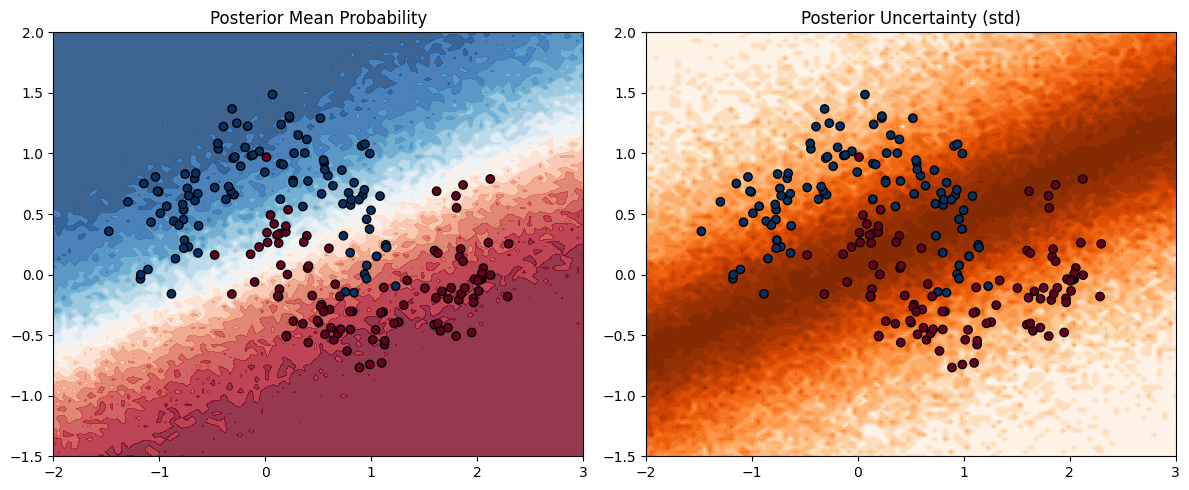

In [27]:
# Solution 1: Bayesian Logistic Regression
from sklearn.datasets import make_moons

# Generate 2D data
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

def logistic_model(x, y=None):
    w = pyro.sample("w", dist.Normal(torch.zeros(2), torch.ones(2)).to_event(1))
    b = pyro.sample("b", dist.Normal(0., 1.))
    
    logits = (x * w).sum(dim=-1) + b
    
    with pyro.plate("data", x.shape[0]):
        pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y.float() if y is not None else None)
    
    return logits

pyro.clear_param_store()
guide = autoguide.AutoNormal(logistic_model)
svi = SVI(logistic_model, guide, Adam({"lr": 0.05}), loss=Trace_ELBO())

for _ in range(2000):
    svi.step(X, y)

# Visualize decision boundary with uncertainty
xx, yy = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-1.5, 2, 100))
X_grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

predictive = Predictive(logistic_model, guide=guide, num_samples=100)
samples = predictive(X_grid)

probs = torch.sigmoid(samples["obs"]).mean(dim=0).numpy().reshape(xx.shape)
uncertainty = torch.sigmoid(samples["obs"]).std(dim=0).numpy().reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].contourf(xx, yy, probs, levels=20, cmap='RdBu_r', alpha=0.8)
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu_r', edgecolors='black')
axes[0].set_title('Posterior Mean Probability')

axes[1].contourf(xx, yy, uncertainty, levels=20, cmap='Oranges')
axes[1].scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu_r', edgecolors='black')
axes[1].set_title('Posterior Uncertainty (std)')

plt.tight_layout()
plt.show()

In [28]:
# Solution 2: Heteroscedastic BNN
class HeteroscedasticBNN(PyroModule):
    """BNN that predicts both mean and variance."""
    
    def __init__(self, hidden_dim=20, prior_scale=1.0):
        super().__init__()
        
        # Shared layers
        self.fc1 = PyroModule[nn.Linear](1, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hidden_dim, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hidden_dim]).to_event(1))
        
        # Mean head
        self.fc_mean = PyroModule[nn.Linear](hidden_dim, 1)
        self.fc_mean.weight = PyroSample(dist.Normal(0., prior_scale).expand([1, hidden_dim]).to_event(2))
        self.fc_mean.bias = PyroSample(dist.Normal(0., prior_scale).expand([1]).to_event(1))
        
        # Variance head (predicts log variance)
        self.fc_var = PyroModule[nn.Linear](hidden_dim, 1)
        self.fc_var.weight = PyroSample(dist.Normal(0., prior_scale).expand([1, hidden_dim]).to_event(2))
        self.fc_var.bias = PyroSample(dist.Normal(0., prior_scale).expand([1]).to_event(1))
    
    def forward(self, x, y=None):
        h = torch.tanh(self.fc1(x))
        mu = self.fc_mean(h).squeeze(-1)
        log_var = self.fc_var(h).squeeze(-1)
        sigma = torch.exp(0.5 * log_var) + 0.01  # Add small constant for stability
        
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu, sigma

# Generate heteroscedastic data
x_het = torch.linspace(-2, 2, 100).unsqueeze(1)
noise_scale = 0.1 + 0.5 * torch.abs(x_het)  # Noise increases with |x|
y_het = torch.sin(2 * x_het) + torch.randn_like(x_het) * noise_scale
y_het = y_het.squeeze()

pyro.clear_param_store()
het_bnn = HeteroscedasticBNN(hidden_dim=20)
guide = autoguide.AutoDiagonalNormal(het_bnn)
svi = SVI(het_bnn, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

for step in range(3000):
    svi.step(x_het, y_het)

# Predict
x_test = torch.linspace(-3, 3, 100).unsqueeze(1)
predictive = Predictive(het_bnn, guide=guide, num_samples=200, return_sites=["obs", "_RETURN"])
samples = predictive(x_test)

obs = samples["obs"]
mean_pred = obs.mean(dim=0)
std_pred = obs.std(dim=0)

plt.figure(figsize=(10, 6))
plt.scatter(x_het, y_het, alpha=0.5, label='Data')
plt.plot(x_test, mean_pred, 'r-', label='Mean prediction', linewidth=2)
plt.fill_between(x_test.squeeze(), mean_pred - 2*std_pred, mean_pred + 2*std_pred,
                 alpha=0.3, color='red', label='95% interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Heteroscedastic BNN: Learned Input-Dependent Noise')
plt.show()

TypeError: expected Tensor as element 0 in argument 0, but got tuple

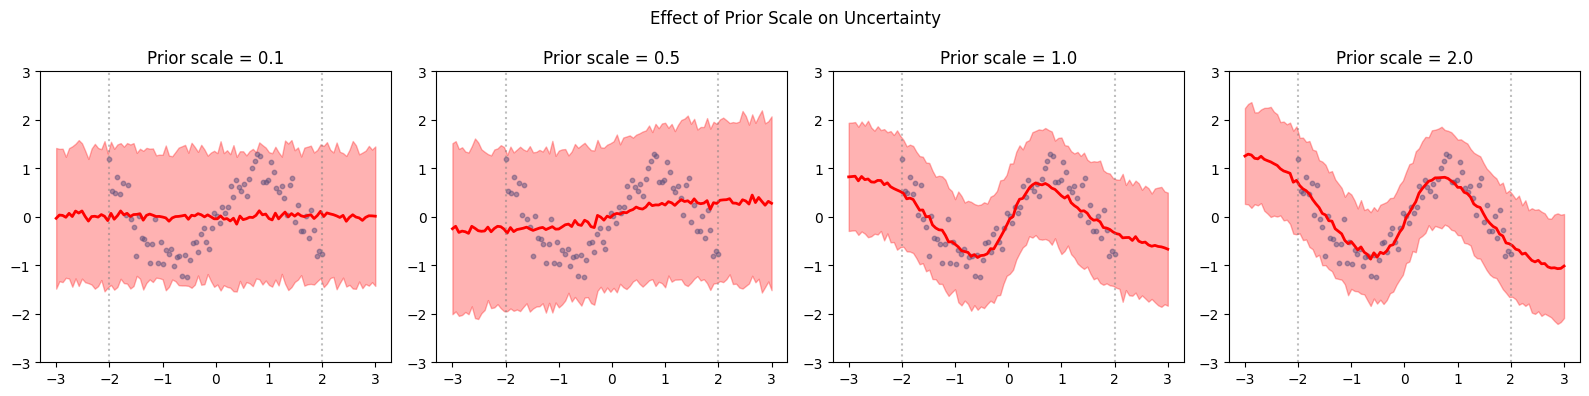

Observations:
- Smaller prior scale → tighter uncertainty, may underfit
- Larger prior scale → wider uncertainty, especially OOD
- Prior acts as regularization


In [29]:
# Solution 3: Prior Sensitivity
prior_scales = [0.1, 0.5, 1.0, 2.0]
results = {}

for scale in prior_scales:
    pyro.clear_param_store()
    
    model = BayesianMLP(prior_scale=scale)
    guide = autoguide.AutoDiagonalNormal(model)
    svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())
    
    for _ in range(2000):
        svi.step(x_nl, y_nl)
    
    # Get predictions
    predictive = Predictive(model, guide=guide, num_samples=200)
    samples = predictive(x_test_nl)
    
    results[scale] = {
        'mean': samples['obs'].mean(dim=0),
        'std': samples['obs'].std(dim=0)
    }

# Visualize
fig, axes = plt.subplots(1, len(prior_scales), figsize=(16, 4))

for ax, scale in zip(axes, prior_scales):
    mean = results[scale]['mean']
    std = results[scale]['std']
    
    ax.scatter(x_nl, y_nl, alpha=0.5, s=10)
    ax.plot(x_test_nl, mean, 'r-', linewidth=2)
    ax.fill_between(x_test_nl.squeeze(), mean - 2*std, mean + 2*std, alpha=0.3, color='red')
    ax.axvline(x=-2, color='gray', linestyle=':', alpha=0.5)
    ax.axvline(x=2, color='gray', linestyle=':', alpha=0.5)
    ax.set_title(f'Prior scale = {scale}')
    ax.set_ylim(-3, 3)

plt.suptitle('Effect of Prior Scale on Uncertainty')
plt.tight_layout()
plt.show()

print("Observations:")
print("- Smaller prior scale → tighter uncertainty, may underfit")
print("- Larger prior scale → wider uncertainty, especially OOD")
print("- Prior acts as regularization")